In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder\
    .config("spark.executor.memory", '32g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '8') \
    .config("spark.driver.memory",'32g') \
    .getOrCreate()




In [2]:
sc = spark.sparkContext


In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from PIL import Image
import numpy as np
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
import os
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors


%matplotlib inline

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
import re

In [5]:
data_dir = "/project/ds5559/BioNerds/ham"
os.chdir('/project/ds5559/BioNerds/ham')

In [6]:
!ls

HAM10000_images_part_1	archive.zip	      hmnist_8_8_L.csv
HAM10000_images_part_2	hmnist_28_28_L.csv    hmnist_8_8_RGB.csv
HAM10000_metadata.csv	hmnist_28_28_RGB.csv


In [7]:
images1 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/project/ds5559/BioNerds/ham/HAM10000_images_part_1")

In [8]:
images2 = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("/project/ds5559/BioNerds/ham/HAM10000_images_part_2")

In [9]:
images1.show(2)

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/project/ds5...|2019-10-06 20:55:50|459172|[FF D8 FF DB 00 4...|
|file:/project/ds5...|2019-10-06 20:56:18|447988|[FF D8 FF DB 00 4...|
+--------------------+-------------------+------+--------------------+
only showing top 2 rows



In [10]:
model = ResNet50(include_top=False)

In [11]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
  """
  Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
  """
  model = ResNet50(weights=None, include_top=False)
  model.set_weights(bc_model_weights.value)
  return model


In [12]:
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)


In [13]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/usr/local/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [14]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
# We can now run featurization on our entire Spark DataFrame.
# NOTE: This can take a long time (about 10 minutes) since it applies a large model to the full dataset.
features_df1 = images1.repartition(16).select(col("path"), featurize_udf("content").alias("features"))
#features_df.write.mode("overwrite").parquet("dbfs:/ml/tmp/flower_photos_features")
features_df2 = images2.repartition(16).select(col("path"), featurize_udf("content").alias("features"))

In [15]:
print("number of pictures in folder 1: {}".format(features_df1.count()))
print("number of pictures in folder 2: {}".format(features_df2.count()))

number of pictures in folder 1: 5000
number of pictures in folder 2: 5015


In [16]:
print(features_df1.columns)
print(features_df2.columns)

['path', 'features']
['path', 'features']


In [17]:
features_df = features_df1.union(features_df2)
print("number of pictures in combined dataframe: {}".format(features_df.count()))

number of pictures in combined dataframe: 10015


In [18]:
features_df.persist()

DataFrame[path: string, features: array<float>]

In [19]:
features_df.select('path').show(5, truncate = False)

+-------------------------------------------------------------------------+
|path                                                                     |
+-------------------------------------------------------------------------+
|file:/project/ds5559/BioNerds/ham/HAM10000_images_part_1/ISIC_0026343.jpg|
|file:/project/ds5559/BioNerds/ham/HAM10000_images_part_1/ISIC_0027333.jpg|
|file:/project/ds5559/BioNerds/ham/HAM10000_images_part_1/ISIC_0026964.jpg|
|file:/project/ds5559/BioNerds/ham/HAM10000_images_part_1/ISIC_0028228.jpg|
|file:/project/ds5559/BioNerds/ham/HAM10000_images_part_1/ISIC_0029303.jpg|
+-------------------------------------------------------------------------+
only showing top 5 rows



In [20]:
meta_df = spark.read.csv('/project/ds5559/BioNerds/ham/HAM10000_metadata.csv', header = True, inferSchema = True)

In [21]:
meta_df.count()

10015

In [22]:
meta_df.cache

<bound method DataFrame.cache of DataFrame[lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string]>

In [23]:
meta_df.show(5)

+-----------+------------+---+-------+----+----+------------+
|  lesion_id|    image_id| dx|dx_type| age| sex|localization|
+-----------+------------+---+-------+----+----+------------+
|HAM_0000118|ISIC_0027419|bkl|  histo|80.0|male|       scalp|
|HAM_0000118|ISIC_0025030|bkl|  histo|80.0|male|       scalp|
|HAM_0002730|ISIC_0026769|bkl|  histo|80.0|male|       scalp|
|HAM_0002730|ISIC_0025661|bkl|  histo|80.0|male|       scalp|
|HAM_0001466|ISIC_0031633|bkl|  histo|75.0|male|         ear|
+-----------+------------+---+-------+----+----+------------+
only showing top 5 rows



In [24]:
pathToID = udf(lambda z: toClass(z), StringType())
spark.udf.register("pathToID", pathToID)
def toClass(s):
    p = re.compile("ISIC_[0-9]*")
    result = p.search(s)
    return(result.group(0))


In [25]:
new = features_df.withColumn('ID', pathToID('path'))#class_from_path(col('path')))

In [26]:
new.select('ID').show(5)

+------------+
|          ID|
+------------+
|ISIC_0026343|
|ISIC_0027333|
|ISIC_0026964|
|ISIC_0028228|
|ISIC_0029303|
+------------+
only showing top 5 rows



In [27]:
new.cache

<bound method DataFrame.cache of DataFrame[path: string, features: array<float>, ID: string]>

In [28]:
new.select('ID').count()

10015

In [29]:
all_df = new.join(meta_df, new.ID == meta_df.image_id, 'left_outer')

In [30]:
all_df.select('ID').count()

10015

In [31]:
all_df.cache

<bound method DataFrame.cache of DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string]>

In [32]:
all_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



In [33]:
all_df.describe().show()

+-------+--------------------+------------+-----------+------------+-----+--------+------------------+-------+---------------+
|summary|                path|          ID|  lesion_id|    image_id|   dx| dx_type|               age|    sex|   localization|
+-------+--------------------+------------+-----------+------------+-----+--------+------------------+-------+---------------+
|  count|               10015|       10015|      10015|       10015|10015|   10015|              9958|  10015|          10015|
|   mean|                null|        null|       null|        null| null|    null|51.863828077927295|   null|           null|
| stddev|                null|        null|       null|        null| null|    null| 16.96861369249536|   null|           null|
|    min|file:/project/ds5...|ISIC_0024306|HAM_0000000|ISIC_0024306|akiec|confocal|               0.0| female|        abdomen|
|    max|file:/project/ds5...|ISIC_0034320|HAM_0007628|ISIC_0034320| vasc|   histo|              85.0|unknown|u

In [34]:
def NullorNoNull(df, a):
    df.filter(df[a].isNull()).show()

In [35]:
for i in all_df.columns:
    print("checking null values in column: {}".format(i))
    NullorNoNull(all_df, i)

checking null values in column: path
+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+

checking null values in column: features
+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+

checking null values in column: ID
+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+

checking null values

In [36]:
all_df.filter(all_df['age'].isNull()).count()

57

<AxesSubplot:ylabel='Frequency'>

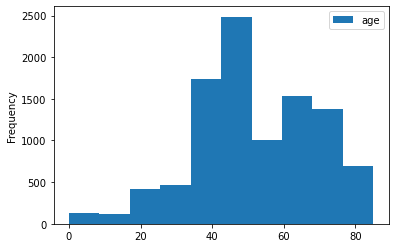

In [37]:
all_df.filter(all_df['age'].isNotNull()).select('age').toPandas().plot.hist()

In [38]:
all_df.filter(all_df['age'].isNull()).select(['age','sex']).show(57)

+----+-------+
| age|    sex|
+----+-------+
|null| female|
|null|   male|
|null| female|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null|   male|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null|unknown|
|null|unknown|
|null|unknown|
|null| female|
|null|unknown|
|null|unknown|
|null|unknown|
|null|   male|
|null| female|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
|null|unknown|
+----+-------+



In [39]:
all_df.groupBy('sex').count().show()

+-------+-----+
|    sex|count|
+-------+-----+
|unknown|   57|
| female| 4552|
|   male| 5406|
+-------+-----+



<AxesSubplot:xlabel='sex'>

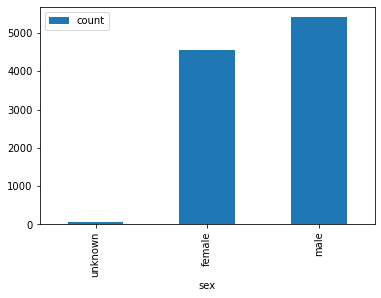

In [40]:
all_df.groupBy('sex').count().toPandas().plot.bar(x='sex', y='count')

In [41]:
all_df.filter(col("sex") == 'unknown').select('ID').show(57, truncate = False)

+------------+
|ID          |
+------------+
|ISIC_0033417|
|ISIC_0034080|
|ISIC_0033751|
|ISIC_0033190|
|ISIC_0034186|
|ISIC_0033391|
|ISIC_0032946|
|ISIC_0033064|
|ISIC_0032945|
|ISIC_0032578|
|ISIC_0032599|
|ISIC_0034019|
|ISIC_0033597|
|ISIC_0033330|
|ISIC_0033685|
|ISIC_0033631|
|ISIC_0032814|
|ISIC_0033375|
|ISIC_0033882|
|ISIC_0033841|
|ISIC_0033982|
|ISIC_0033490|
|ISIC_0033733|
|ISIC_0033065|
|ISIC_0033028|
|ISIC_0034252|
|ISIC_0032667|
|ISIC_0032740|
|ISIC_0033119|
|ISIC_0034130|
|ISIC_0033809|
|ISIC_0033332|
|ISIC_0033535|
|ISIC_0034154|
|ISIC_0032679|
|ISIC_0033864|
|ISIC_0032966|
|ISIC_0034266|
|ISIC_0033628|
|ISIC_0034045|
|ISIC_0033374|
|ISIC_0034195|
|ISIC_0033735|
|ISIC_0032529|
|ISIC_0032738|
|ISIC_0032852|
|ISIC_0033877|
|ISIC_0033782|
|ISIC_0033829|
|ISIC_0032789|
|ISIC_0033750|
|ISIC_0033472|
|ISIC_0034283|
|ISIC_0033153|
|ISIC_0033515|
|ISIC_0033353|
|ISIC_0033187|
+------------+



In [42]:
all_df.filter("ID is null").show()

+----+--------+---+---------+--------+---+-------+---+---+------------+
|path|features| ID|lesion_id|image_id| dx|dx_type|age|sex|localization|
+----+--------+---+---------+--------+---+-------+---+---+------------+
+----+--------+---+---------+--------+---+-------+---+---+------------+



In [43]:

all_df.groupBy('localization').count().show()

+---------------+-----+
|   localization|count|
+---------------+-----+
|        abdomen| 1022|
|          chest|  407|
|           hand|   90|
|           back| 2192|
|           face|  745|
|        unknown|  234|
|        genital|   48|
|          trunk| 1404|
|           foot|  319|
|            ear|   56|
|           neck|  168|
|upper extremity| 1118|
|          scalp|  128|
|          acral|    7|
|lower extremity| 2077|
+---------------+-----+



<AxesSubplot:xlabel='localization'>

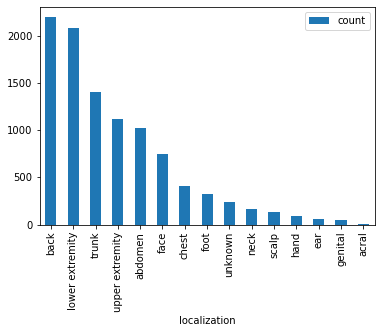

In [44]:
all_df.groupBy('localization').count().sort("count", ascending=False).toPandas().plot.bar(x='localization', y='count')

In [45]:
all_df.groupBy('dx').count().sort("count", ascending=False).show()

+-----+-----+
|   dx|count|
+-----+-----+
|   nv| 6705|
|  mel| 1113|
|  bkl| 1099|
|  bcc|  514|
|akiec|  327|
| vasc|  142|
|   df|  115|
+-----+-----+



<AxesSubplot:xlabel='dx'>

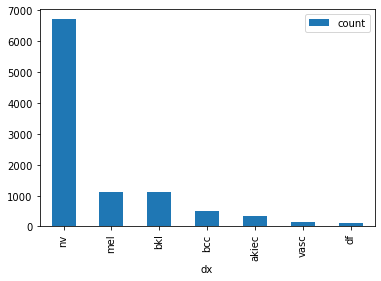

In [46]:
all_df.groupBy('dx').count().sort("count", ascending=False).toPandas().plot.bar(x='dx', y='count')

In [47]:
all_df.groupBy('dx_type').count().sort("count", ascending=False).show()

+---------+-----+
|  dx_type|count|
+---------+-----+
|    histo| 5340|
|follow_up| 3704|
|consensus|  902|
| confocal|   69|
+---------+-----+



<AxesSubplot:xlabel='dx_type'>

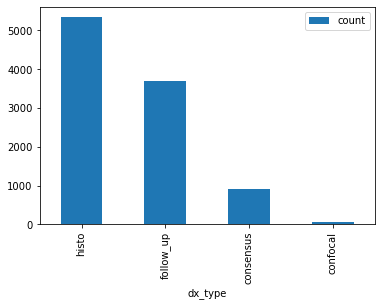

In [48]:
all_df.groupBy('dx_type').count().sort("count", ascending=False).toPandas().plot.bar(x='dx_type', y='count')

In [49]:
# removing null and unknown rows
clean_df = all_df.filter((col("sex") != 'unknown') & (col("age").isNotNull()))

In [50]:
all_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



In [51]:
clean_df.count()

9948

In [52]:
clean_df.cache

<bound method DataFrame.cache of DataFrame[path: string, features: array<float>, ID: string, lesion_id: string, image_id: string, dx: string, dx_type: string, age: double, sex: string, localization: string]>

<AxesSubplot:ylabel='Frequency'>

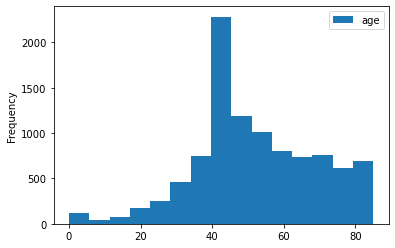

In [53]:
clean_df.select("age").sort('age', ascending = True).toPandas().plot.hist(bins = 15)

In [54]:
clean_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)



In [55]:
clean_df.select('features').show(5, truncate = True)

+--------------------+
|            features|
+--------------------+
|[0.0, 0.0, 0.0, 0...|
|[4.762246, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+
only showing top 5 rows



In [56]:
from pyspark.ml.linalg import Vectors, VectorUDT
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

clean_df = clean_df.select("*", to_vector("features").alias("features_2"))

In [101]:
# save dataframe
# clean_df.write.save("/project/ds5559/BioNerds/saved_data/clean_df.parquet")

In [57]:
A=clean_df.select('features_2')

In [59]:
A.show(5)

+--------------------+
|          features_2|
+--------------------+
|[0.0,0.0,0.0,0.0,...|
|[4.76224613189697...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|
+--------------------+
only showing top 5 rows



In [58]:
A.cache()

DataFrame[features_2: vector]

In [61]:
# get size of features vector
len(A.first()[0])

100352

In [62]:
%%time
from pyspark.ml.feature import PCA
pca = PCA(k=50,inputCol="features_2", outputCol="pcaFeatures")

CPU times: user 1.51 ms, sys: 192 µs, total: 1.7 ms
Wall time: 19.5 ms


In [ ]:
%%time 
model = pca.fit(A)

In [ ]:
%%time 
np.round(100.00*model.explainedVariance.toArray(),2)

In [ ]:
%%time 
model.save("pcaModel_50")

In [ ]:
%%time 
result = model.transform(A).select("pcaFeatures")

In [ ]:
%%time 
result.toPandas().to_csv('pca_50.csv')

In [97]:
var = pd.DataFrame ({'variance':np.round(model.explained_variance_ratio_ * 100,4), 
                    'PC':['p' + str(i) for i in range(1,51)]})

ax = var.plot(kind='bar', figsize=(10,7), color="coral", fontsize=13, legend = False)
ax.set_alpha(0.8)
ax.set_title("Variance Explained", fontsize=18)
ax.set_xlabel("PC", fontsize=16)
ax.set_ylabel("Variance Explained (%)", fontsize=16)

rects = ax.patches
labels = list(var['variance'])
labels = [str(variance) +'%' for variance in labels]
                          

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha ='center', va='bottom')

AttributeError: 'Model' object has no attribute 'explained_variance_ratio_'

In [59]:
pca_50 = pd.read_csv("/project/ds5559/BioNerds/PCA/pca_50.csv")

In [60]:
pca_50.head()

,Unnamed: 0,pcaFeatures
0,0,"[76.20729426876972,-14.677847814621085,-129.34..."
1,1,"[197.7734979859273,78.83332946949054,101.00611..."
2,2,"[-15.332457313154686,-5.22253971908665,-74.784..."
3,3,"[111.84681933094677,-53.5019045760116,123.0944..."
4,4,"[-64.37244383734614,40.48074784303648,-72.7146..."


In [61]:
#clean_df.show(5)

In [62]:
from pyspark.ml.feature import VectorSlicer
import numpy as np
vslicer = VectorSlicer(inputCol="features_2", outputCol="100_feature", indices=np.arange(2,101))

In [63]:
small_feature = vslicer.transform(A)

In [64]:
small_feature.show(5)

+--------------------+--------------------+
|          features_2|         100_feature|
+--------------------+--------------------+
|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|[4.76224613189697...|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+
only showing top 5 rows



In [65]:
B = small_feature.select("100_feature")

In [66]:
B.cache()

DataFrame[100_feature: vector]

In [67]:
len(B.first()[0])

99

In [68]:
%%time
from pyspark.ml.feature import PCA
pca = PCA(k=3,inputCol="100_feature", outputCol="pcaFeatures")

CPU times: user 589 µs, sys: 217 µs, total: 806 µs
Wall time: 6.5 ms


In [70]:
%%time 
model_B = pca.fit(B)

CPU times: user 18.8 ms, sys: 6.19 ms, total: 25 ms
Wall time: 2min 17s


In [71]:
np.round(100.00*model_B.explainedVariance.toArray(),4)

array([21.3114, 12.7066, 10.8932])

In [101]:
model_B.save("/project/ds5559/BioNerds/PCA/pcaModel_B")

In [103]:
pcaModel_B = PCAModel.load("/project/ds5559/BioNerds/PCA/pcaModel_B")

In [104]:
pcaModel_B.getK()

3

In [105]:
np.round(pcaModel_B.explainedVariance * 100,4)

array([21.3114, 12.7066, 10.8932])

In [62]:
pca_path = "/project/ds5559/BioNerds/PCA/pcaModel_50"

In [63]:
%%time
from pyspark.ml.feature import PCAModel
pcaModel_50 = PCAModel.load(pca_path)

CPU times: user 2.4 ms, sys: 1.53 ms, total: 3.93 ms
Wall time: 1.62 s


In [64]:
pcaModel_50.getK()

50

In [65]:
np.round(pcaModel_50.explainedVariance * 100,4)

array([14.9966, 10.977 ,  8.2999,  6.8665,  4.6491,  3.7943,  3.0949,
        2.9502,  2.5735,  2.4466,  2.3646,  2.2678,  2.216 ,  1.9665,
        1.7569,  1.7116,  1.5317,  1.4089,  1.2883,  1.2131,  1.1358,
        1.0878,  1.0397,  1.0082,  0.9545,  0.9392,  0.9045,  0.8737,
        0.8253,  0.7958,  0.7776,  0.7605,  0.7346,  0.6924,  0.6711,
        0.66  ,  0.6504,  0.6287,  0.6168,  0.5959,  0.5902,  0.5647,
        0.5495,  0.5443,  0.5354,  0.5278,  0.504 ,  0.4988,  0.4854,
        0.4734])

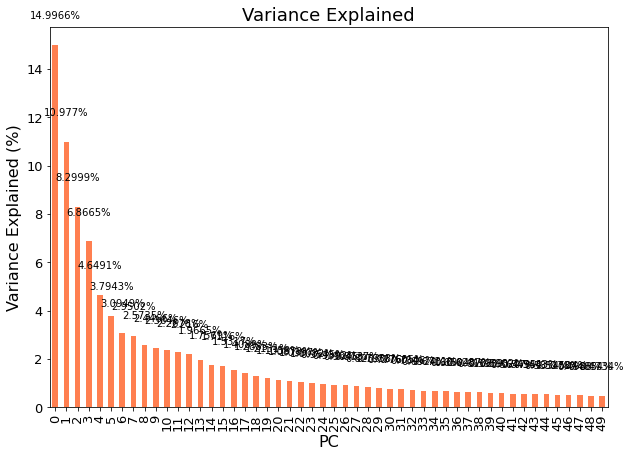

In [90]:
var = pd.DataFrame ({'variance':np.round(pcaModel_50.explainedVariance * 100,4), 'PC':['p' + str(i) for i in range(1,51)]})

ax = var.plot(kind='bar', figsize=(10,7), color="coral", fontsize=13, legend = False)
ax.set_alpha(0.8)
ax.set_title("Variance Explained", fontsize=18)
ax.set_xlabel("PC", fontsize=16)
ax.set_ylabel("Variance Explained (%)", fontsize=16)

rects = ax.patches
labels = list(var['variance'])
labels = [str(variance) +'%' for variance in labels]
                          

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
            ha ='center', va='bottom')

In [115]:
var.head()

,variance,PC
0,14.9966,p1
1,10.9770,p2
2,8.2999,p3
3,6.8665,p4
4,4.6491,p5


In [95]:
var['variance'].sum()

99.99999999999999

In [100]:
var.iloc[:35,:1].sum()

variance    91.5747
dtype: float64

In [ ]:
#clean_df.select('features_2')

In [66]:
%%time 
result = pcaModel_50.transform(clean_df)

CPU times: user 1.69 ms, sys: 632 µs, total: 2.32 ms
Wall time: 40 ms


In [67]:
result.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|localization|          features_2|         pcaFeatures|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0026343|HAM_0002346|ISIC_0026343|bcc|    histo|70.0|  male|        face|[0.0,0.0,0.0,0.0,...|[76.2072942687697...|
|file:/project/ds5...|[4.762246, 0.0, 0...|ISIC_0027333|HAM_0000564|ISIC_0027333| nv|follow_up|40.0|  male|        foot|[4.76224613189697...|[197.773497985927...|
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0026964|HAM_0004372|ISIC_0026964| nv|    histo|65.0|  male|       scalp|[0.0,0.0,0.0,0.0,...|[-15.332457313154...|
|file:/project/ds5...|

In [68]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml import Pipeline

In [69]:

label_index = StringIndexer(inputCol = 'dx', outputCol = 'indexed_dx').fit(result)
label_sex = StringIndexer(inputCol = 'sex', outputCol = 'indexed_sex').fit(result)
loc_index = StringIndexer(inputCol = 'localization', outputCol = 'indexed_loc').fit(result)
vec_assemb = VectorAssembler(inputCols = ['pcaFeatures','indexed_loc', 'indexed_sex',"age" ], outputCol = 'Feature_vec')

pipe = Pipeline(stages = [label_index, label_sex, loc_index, vec_assemb])

In [70]:
%%time
model_lr = pipe.fit(result)

CPU times: user 215 µs, sys: 0 ns, total: 215 µs
Wall time: 185 µs


In [71]:
%%time
result = model_lr.transform(result)
result.show(5)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|localization|          features_2|         pcaFeatures|indexed_dx|indexed_sex|indexed_loc|         Feature_vec|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+------------+--------------------+--------------------+----------+-----------+-----------+--------------------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0026343|HAM_0002346|ISIC_0026343|bcc|    histo|70.0|  male|        face|[0.0,0.0,0.0,0.0,...|[76.2072942687697...|       3.0|        0.0|        5.0|[76.2072942687697...|
|file:/project/ds5...|[4.762246, 0.0, 0...|ISIC_0027333|HAM_0000564|ISIC_0027333| nv|follow_up|40.0|  male|        foot|[4.7

In [73]:
%%time
mlr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,  family="multinomial")
mlr.setFeaturesCol("Feature_vec").setThreshold(0.5).setLabelCol("indexed_dx")

model_mlr = mlr.fit(result)

CPU times: user 56.2 ms, sys: 30.3 ms, total: 86.5 ms
Wall time: 3min 8s


In [74]:
%%time
predictions =model_mlr.transform(result)

CPU times: user 3.1 ms, sys: 1.41 ms, total: 4.51 ms
Wall time: 24.5 ms


In [75]:
%%time
predictions.show(10)

+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+--------------------+--------------------+----------+
|                path|            features|          ID|  lesion_id|    image_id| dx|  dx_type| age|   sex|   localization|          features_2|         pcaFeatures|indexed_dx|indexed_sex|indexed_loc|         Feature_vec|       rawPrediction|         probability|prediction|
+--------------------+--------------------+------------+-----------+------------+---+---------+----+------+---------------+--------------------+--------------------+----------+-----------+-----------+--------------------+--------------------+--------------------+----------+
|file:/project/ds5...|[0.0, 0.0, 0.0, 0...|ISIC_0026343|HAM_0002346|ISIC_0026343|bcc|    histo|70.0|  male|           face|[0.0,0.0,0.0,0.0,...|[76.2072942687697...|       3.0

In [76]:
%%time
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)

CPU times: user 16.2 ms, sys: 5.21 ms, total: 21.4 ms
Wall time: 2min 51s


0.579311582564639

In [77]:
temp = predictions.select("probability")
temp.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------+
|probability                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.312757171581578,0.18952412461607773,0.1829860251648916,0.1836009329515677,0.08274686582285147,0.02668139751640029,0.021703482346633194]      |
|[0.6686878040182501,0.1386475054608541,0.11736390383149996,0.02568807742595291,0.030155780558395136,0.01053782850710568,0.008919100197942063]   |
|[0.6297129551471502,0.09530716644275074,0.14595247067523545,0.05979432974281129,0.04428523984635,0.013211123372227542,0.01173671477347485]      |
|[0.516098486530371,0.21753287177976782,0.12360086473545646,0.0688976483444067,0.045927390076189,0.015016719430098862,

In [ ]:
mlr_new = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0,  family="multinomial")
mlr_new.setFeaturesCol("pcaFeatures").setThreshold(0.5).setLabelCol("indexed_dx")

In [ ]:
model_mlr_new = mlr_new.fit(result_new)

In [ ]:
predictions_new =model_mlr_new.transform(result_new)

In [80]:
cv_table = result.select("Feature_vec", "indexed_dx")
cv_table.cache()

DataFrame[Feature_vec: vector, indexed_dx: double]

In [87]:
test_model = mlr.fit(cv_table)

In [88]:
test_resutl=test_model.transform(cv_table)

In [90]:
test_resutl.show(5)

+--------------------+----------+--------------------+--------------------+----------+
|         Feature_vec|indexed_dx|       rawPrediction|         probability|prediction|
+--------------------+----------+--------------------+--------------------+----------+
|[76.2072942687697...|       3.0|[1.14694947832498...|[0.31275717158157...|       0.0|
|[197.773497985927...|       0.0|[2.59130277127995...|[0.66868780401825...|       0.0|
|[-15.332457313154...|       0.0|[2.31512216167548...|[0.62971295514715...|       0.0|
|[111.846819330946...|       1.0|[1.99289828118115...|[0.51609848653037...|       0.0|
|[-64.372443837346...|       0.0|[2.69449865758699...|[0.74635910461025...|       0.0|
+--------------------+----------+--------------------+--------------------+----------+
only showing top 5 rows



In [92]:
### cross valication

#%%time
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(mlr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(mlr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .build())

In [95]:
%%time
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=mlr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5, \
                    parallelism = 4)

CPU times: user 259 µs, sys: 102 µs, total: 361 µs
Wall time: 341 µs


In [96]:
%%time
cvModel = cv.fit(cv_table)

predictions = cvModel.transform(cv_table)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

IllegalArgumentException: label does not exist. Available: Feature_vec, indexed_dx, rawPrediction, probability, prediction

In [98]:
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_dx")
evaluator.evaluate(predictions)


0.6769218298269912

<AxesSubplot:xlabel='prediction'>

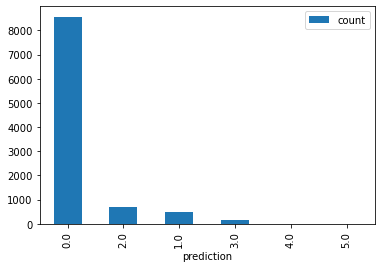

In [99]:
predictions.groupBy('prediction').count().sort("count", ascending=False).toPandas().plot.bar(x='prediction', y='count')

In [99]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from pyspark.ml.functions import vector_to_array

In [100]:
features_df.withColumn("xs", vector_to_array("features_2"))

DataFrame[features_2: vector, xs: array<double>]

KeyboardInterrupt: 

In [ ]:
pca = sklearnPCA().fit(features_df)

In [113]:
# top 3 PCA

from pyspark.ml.feature import PCA

pca = PCA(k=3, inputCol="features_2", outputCol="pcaFeatures")
model = pca.fit(a)
result = model.transform(a).select("pcaFeatures")
result.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[76.20729426876981,-14.677847814621058,-129.34680403772973]|
|[197.77349798592752,78.83332946949068,101.00611309217007]  |
|[-15.332457313154704,-5.222539719086652,-74.78423693519012]|
|[111.84681933094696,-53.50190457601159,123.09444087127144] |
|[-64.37244383734621,40.480747843036575,-72.71462007750468] |
|[-75.96697355563046,24.715679213623464,-130.20284643201387]|
|[-112.99785226689441,10.41743383640928,-102.79837499833081]|
|[122.69137592993083,1.0028075318334584,101.68191406234374] |
|[37.52216526856619,77.454996375307,79.17681800962984]      |
|[234.68590870690812,-44.95756610736397,-5.839721611644651] |
|[99.82443796673181,66.94064060370624,-233.63084696449565]  |
|[83.43750487935363,103.75807673577438,-2.799611961084147]  |
|[-20.417419544586384,19.218709767630266,-88.40101104031429]|
|[158.42

In [116]:
model.save("pcaModel")

In [118]:
result.printSchema()

root
 |-- pcaFeatures: vector (nullable = true)



In [119]:
result.toPandas().to_csv('pca.csv')

In [26]:
to_vector = udf(lambda a: Vectors.dense(a), VectorUDT())

all_df = all_df.select("*", to_vector("features").alias("features_2"))

In [27]:
all_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- ID: string (nullable = true)
 |-- lesion_id: string (nullable = true)
 |-- image_id: string (nullable = true)
 |-- dx: string (nullable = true)
 |-- dx_type: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- localization: string (nullable = true)
 |-- features_2: vector (nullable = true)



In [48]:
#Define preprocessing pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

label_index = StringIndexer(inputCol = 'dx', outputCol = 'indexed_dx').fit(all_df)
label_sex = StringIndexer(inputCol = 'sex', outputCol = 'indexed_sex').fit(all_df)
loc_index = StringIndexer(inputCol = 'localization', outputCol = 'indexed_loc').fit(all_df)
vec_assemb = VectorAssembler(inputCols = ['indexed_loc', 'indexed_sex', 'features_2'], outputCol = 'Feature_vec')
vec_index = VectorIndexer(inputCol = 'Feature_vec', outputCol = 'indexed_features', maxCategories = 100, handleInvalid = 'skip').fit(all_df)

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexed_dx", featuresCol="indexed_features", numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=label_index.labels)


pipe = Pipeline(stages = [label_index, label_sex, loc_index, vec_assemb, vec_index])


IllegalArgumentException: indexed_loc does not exist. Available: path, features, ID, lesion_id, image_id, dx, dx_type, age, sex, localization, features_2

In [ ]:
model = pipe.fit(all_df)

In [36]:
predictions = model.transform(all_df)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

pyspark.ml.pipeline.PipelineModel

In [49]:
li = label_index.fit(all_df)
all_df = li.transform(all_df)

In [53]:
ls = label_sex.fit(all_df)
all_df = ls.transform(all_df)

In [54]:
lci = loc_index.fit(all_df)
all_df = lci.transform(all_df)

In [56]:
va = vec_assemb.transform(all_df)

In [59]:
va.schema

StructType(List(StructField(path,StringType,true),StructField(features,ArrayType(FloatType,true),true),StructField(ID,StringType,true),StructField(lesion_id,StringType,true),StructField(image_id,StringType,true),StructField(dx,StringType,true),StructField(dx_type,StringType,true),StructField(age,DoubleType,true),StructField(sex,StringType,true),StructField(localization,StringType,true),StructField(features_2,VectorUDT,true),StructField(indexed_dx,DoubleType,false),StructField(indexed_sex,DoubleType,false),StructField(indexed_loc,DoubleType,false),StructField(Feature_vec,VectorUDT,true)))

In [61]:
#va.select('Feature_vec').head()
print('why')

why


In [71]:
va.schema

StructType(List(StructField(path,StringType,true),StructField(features,ArrayType(FloatType,true),true),StructField(ID,StringType,true),StructField(lesion_id,StringType,true),StructField(image_id,StringType,true),StructField(dx,StringType,true),StructField(dx_type,StringType,true),StructField(age,DoubleType,true),StructField(sex,StringType,true),StructField(localization,StringType,true),StructField(features_2,VectorUDT,true),StructField(indexed_dx,DoubleType,false),StructField(indexed_sex,DoubleType,false),StructField(indexed_loc,DoubleType,false),StructField(Feature_vec,VectorUDT,true)))

In [72]:
va2 = va.drop('features')

In [ ]:
va3 = va2.select(['ID', 'lesion_ID', 'image_ID', ])

In [74]:
va3.schema

StructType(List(StructField(path,StringType,true),StructField(ID,StringType,true),StructField(lesion_id,StringType,true),StructField(image_id,StringType,true),StructField(dx,StringType,true),StructField(dx_type,StringType,true),StructField(age,DoubleType,true),StructField(sex,StringType,true),StructField(localization,StringType,true),StructField(features_2,VectorUDT,true),StructField(indexed_dx,DoubleType,false),StructField(indexed_sex,DoubleType,false),StructField(indexed_loc,DoubleType,false),StructField(Feature_vec,VectorUDT,true)))

In [73]:
va2.coalesce(1).write.csv('preprocessed_data.csv')

AnalysisException: CSV data source does not support struct<type:tinyint,size:int,indices:array<int>,values:array<double>> data type.;

In [65]:
vi = vec_index.fit(va)


Py4JJavaError: An error occurred while calling o847.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 11 in stage 106.0 failed 1 times, most recent failure: Lost task 11.0 in stage 106.0 (TID 2774, udc-ba27-18, executor driver): java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:223)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:176)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:123)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:539)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.writeValue(UnsafeRowSerializer.scala:69)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:249)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:158)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2194)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeReduce$1(RDD.scala:1127)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeReduce(RDD.scala:1105)
	at org.apache.spark.ml.feature.VectorIndexer.fit(VectorIndexer.scala:150)
	at org.apache.spark.ml.feature.VectorIndexer.fit(VectorIndexer.scala:117)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.io.IOException: No space left on device
	at java.base/java.io.FileOutputStream.writeBytes(Native Method)
	at java.base/java.io.FileOutputStream.write(FileOutputStream.java:354)
	at org.apache.spark.storage.TimeTrackingOutputStream.write(TimeTrackingOutputStream.java:59)
	at java.base/java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:81)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:127)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:223)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:176)
	at java.base/java.io.BufferedOutputStream.write(BufferedOutputStream.java:123)
	at java.base/java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:539)
	at org.apache.spark.sql.execution.UnsafeRowSerializerInstance$$anon$1.writeValue(UnsafeRowSerializer.scala:69)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:249)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:158)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [42]:
pipe.fit(all_df)

Exception ignored in: <function JavaWrapper.__del__ at 0x7ff8e97a7d40>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 42, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'StringIndexer' object has no attribute '_java_obj'


Py4JJavaError: An error occurred while calling o404.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 48.0 failed 1 times, most recent failure: Lost task 7.0 in stage 48.0 (TID 1538, udc-ba27-18, executor driver): java.lang.IllegalArgumentException: requirement failed: VectorIndexer expected 100355 features but found vector of size 3.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.VectorIndexer$CategoryStats.addVector(VectorIndexer.scala:211)
	at org.apache.spark.ml.feature.VectorIndexer.$anonfun$fit$3(VectorIndexer.scala:148)
	at org.apache.spark.ml.feature.VectorIndexer.$anonfun$fit$3$adapted(VectorIndexer.scala:148)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.ml.feature.VectorIndexer.$anonfun$fit$2(VectorIndexer.scala:148)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2194)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1157)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1151)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1220)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeReduce$1(RDD.scala:1127)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.treeReduce(RDD.scala:1105)
	at org.apache.spark.ml.feature.VectorIndexer.fit(VectorIndexer.scala:150)
	at org.apache.spark.ml.feature.VectorIndexer.fit(VectorIndexer.scala:117)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.IllegalArgumentException: requirement failed: VectorIndexer expected 100355 features but found vector of size 3.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.VectorIndexer$CategoryStats.addVector(VectorIndexer.scala:211)
	at org.apache.spark.ml.feature.VectorIndexer.$anonfun$fit$3(VectorIndexer.scala:148)
	at org.apache.spark.ml.feature.VectorIndexer.$anonfun$fit$3$adapted(VectorIndexer.scala:148)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at org.apache.spark.ml.feature.VectorIndexer.$anonfun$fit$2(VectorIndexer.scala:148)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:837)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:837)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:349)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:313)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:127)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:446)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1377)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:449)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
